# 0.0 Imports

In [4]:
import math
import warnings
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

from boruta import BorutaPy
from tabulate import tabulate
from pycorrcat import pycorrcat
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from matplotlib.gridspec import GridSpec

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [5]:
def jupyter_settings():
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container{width:100% !important; }</style>'))
#    pd.options.display.max_columns = None
#   pd.options.display.max_rows = None
#    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    # ignora future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()
    
    
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE' : mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model name': model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])
        

In [6]:
jupyter_settings()

## 0.2 Load Data

In [7]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos dados

In [8]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# rename
df1.columns = new_cols

## 1.2 Data Dimension

In [10]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else  x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year              
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Abr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 
8 : 'Aug', 9 : 'Set', 10 : 'Oct',  11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central tendency and Dispersion
d1 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

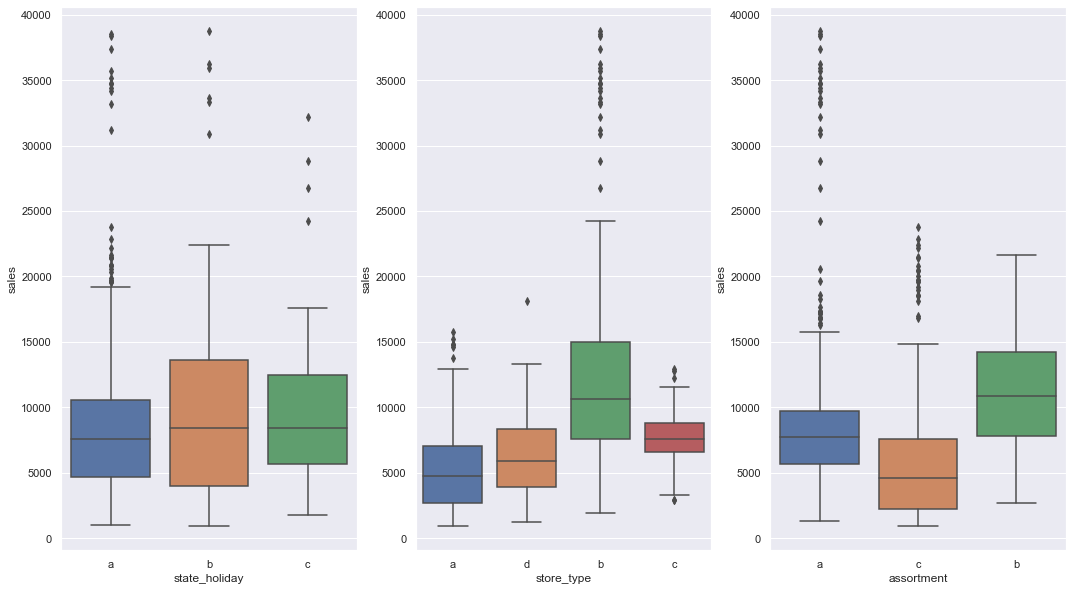

In [19]:
sns.set(rc={'figure.figsize':(18, 10)})

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday' ,y='sales' , data=aux1)

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type' ,y='sales' , data=aux1)

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment' ,y='sales' , data=aux1)

# 2.0 Feature Engineering

In [20]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

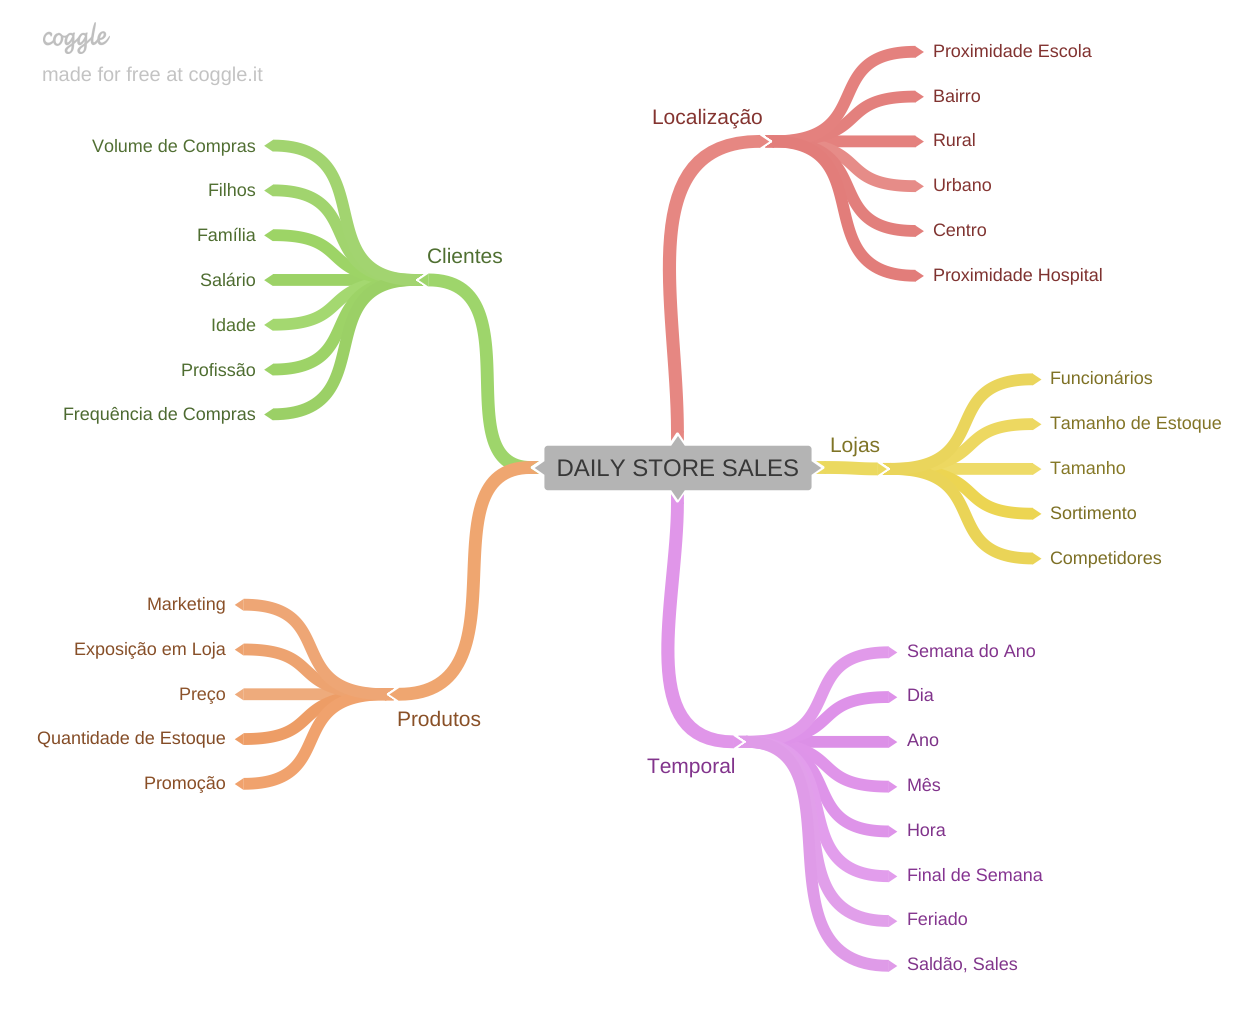

In [21]:
Image('img/MindMapHypothesis.png')

## 2.1.1 Hipóteses Loja

**1.**Lojas com maior quadro de funcionários deveriam vender mais na média.

**2.**Lojas com maior estoque deveriam vender mais na média.

**3.**Lojas com maior porte deveriam vender mais na média.

**4.**Lojas com menor porte deveriam vender menos na média.

**5.**Lojas com maior sortimento deveriam vender mais na média.

**6.**Lojas com competidores mais próximos deveriam vender menos em mediana.

**7.**Lojas com competidores à mais tempo deveriam vendem mais em mediana.

## 2.1.1 Hipóteses Produto

**1.**Lojas que investem mais em Marketing deveriam vender mais na media.

**2.**Lojas quem expõe mais o produto nas vitrines deveriam vender mais na media.

**3.**Lojas que tem preços menores nos produtos deveriam vender mais na media.

**4.**Lojas com promoções mais agressivas ( descontos maiores) deveriam vender mais na media.

**5.**Lojas com promoções ativas por mais tempo em média deveriam vender mais.

**6.**Lojas com mais dias de promoção deveriam vender mais na media.

**7.**Lojas com mais promoções consecutivas deveriam vender mais na media.

## 2.1.1 Hipóteses Tempo

**1.**Lojas deveriam vender menos nos finais de semana.

**2.**Lojas abertas durante o feriado de Natal deveriam vender mais na media.

**3.**Lojas em media deveriam vender mais ao longo dos anos.

**4.**Lojas em media deveriam vender mais depois do dia 10 de cada mês.

**5.**Lojas em media deveriam vender menos durante os feriados escolares.

**6.**Lojas em media deveriam vender mais no segundo semestre do ano.

## 2.2 Lista final de hipóteses

**1.**Lojas com maior sortimento deveriam vender mais na media.

**2.**Lojas com competidores mais próximos deveriam vender menos em mediana.

**3.**Lojas com competidores à mais tempo deveriam vendem mais em mediana.

**4.**Lojas com promoções ativas por mais tempo em media deveriam vender mais.

**5.**Lojas com mais dias de promoção deveriam vender mais na media.

**6.**Lojas com mais promoções consecutivas deveriam vender mais na media.

**7.**Lojas deveriam vender menos nos finais de semana.

**8.**Lojas abertas durante o feriado de Natal deveriam vender mais na media.

**9.**Lojas em media deveriam vender mais ao longo dos anos.

**10.**Lojas em media deveriam vender mais depois do dia 10 de cada mês.

**11.**Lojas em media deveriam vender menos durante os feriados escolares.

**12.**Lojas em media deveriam vender mais no segundo semestre do ano.

## 2.3 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df2.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,...,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday,public_holiday
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d


# 3.0 Filtragem de variáveis

In [24]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise exploratória dos dados

In [27]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

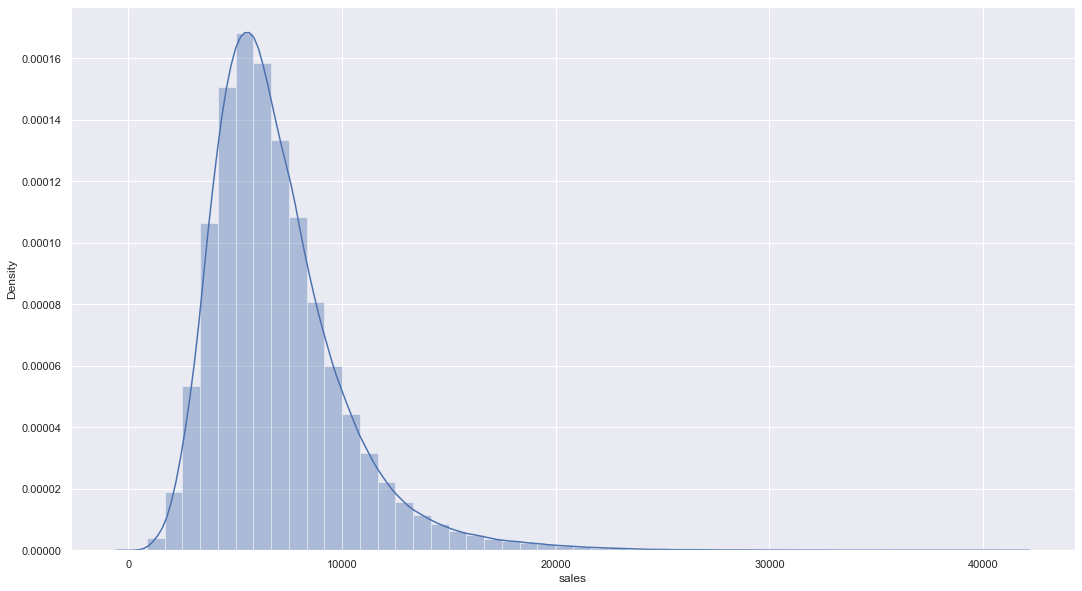

In [28]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable

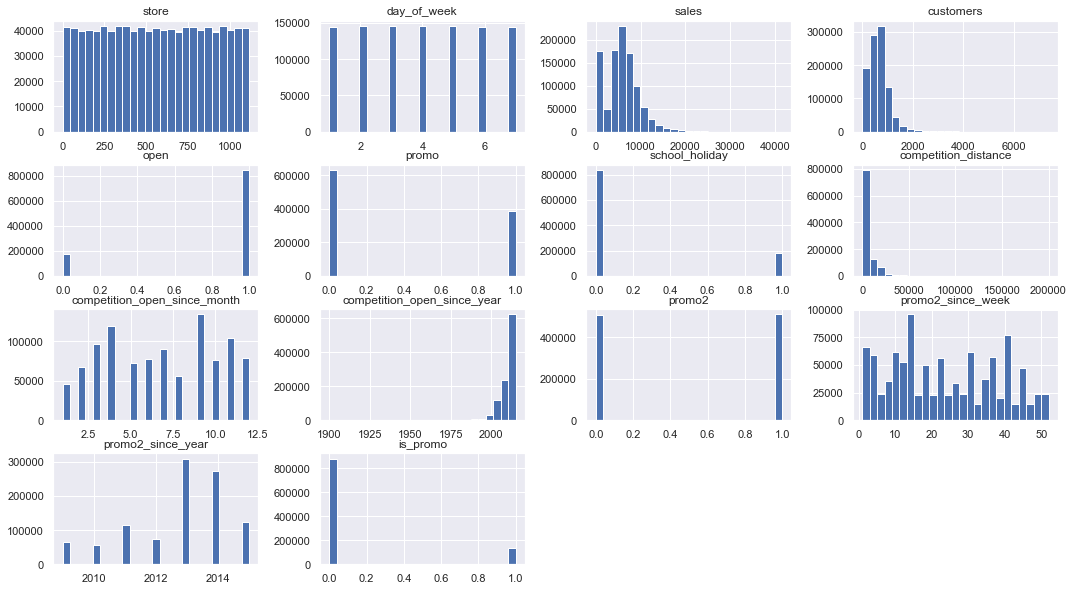

In [29]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

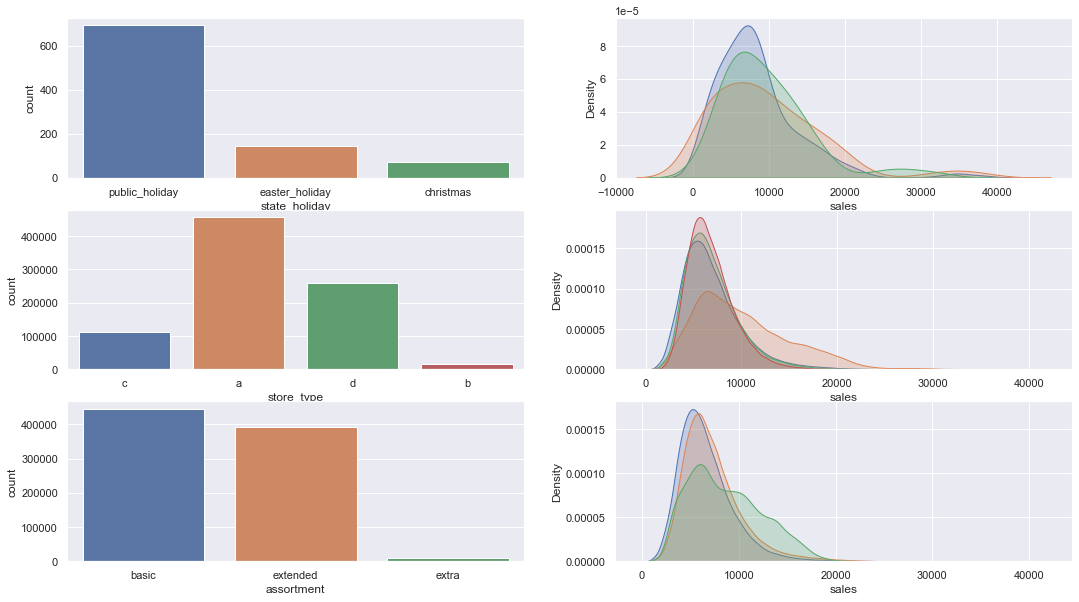

In [30]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='public_holiday', shade=True);

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
            label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
            label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
            label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
            label='d', shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra', shade=True);

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais na media.

**VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem em média MAIS

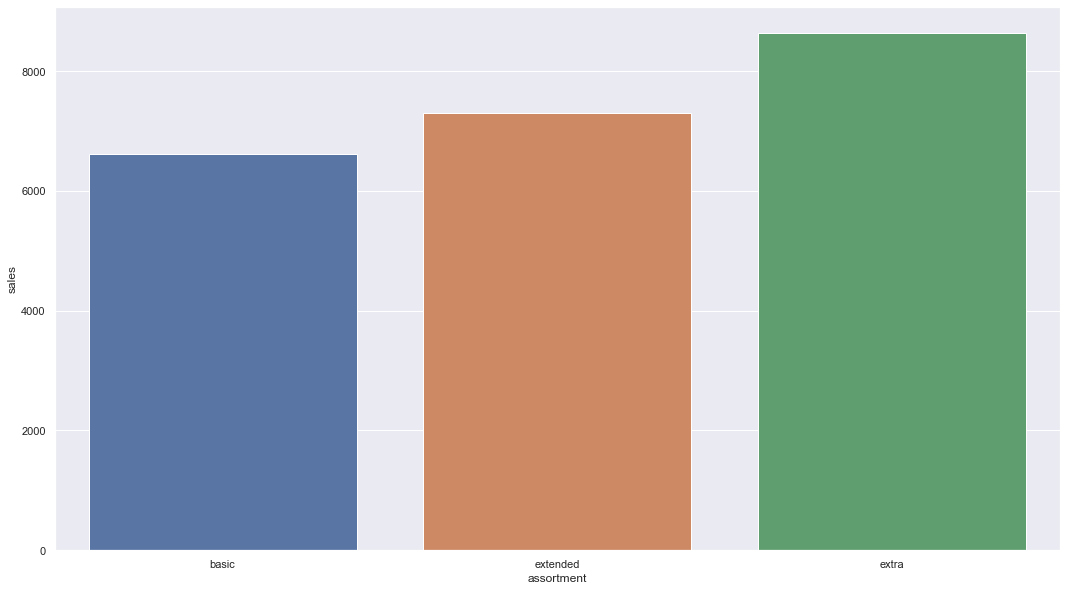

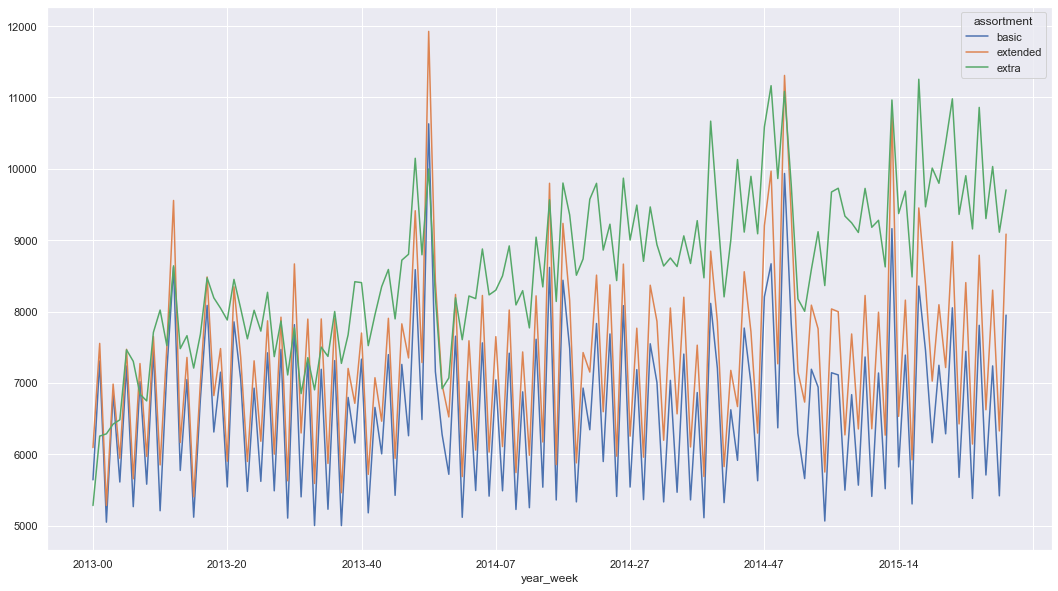

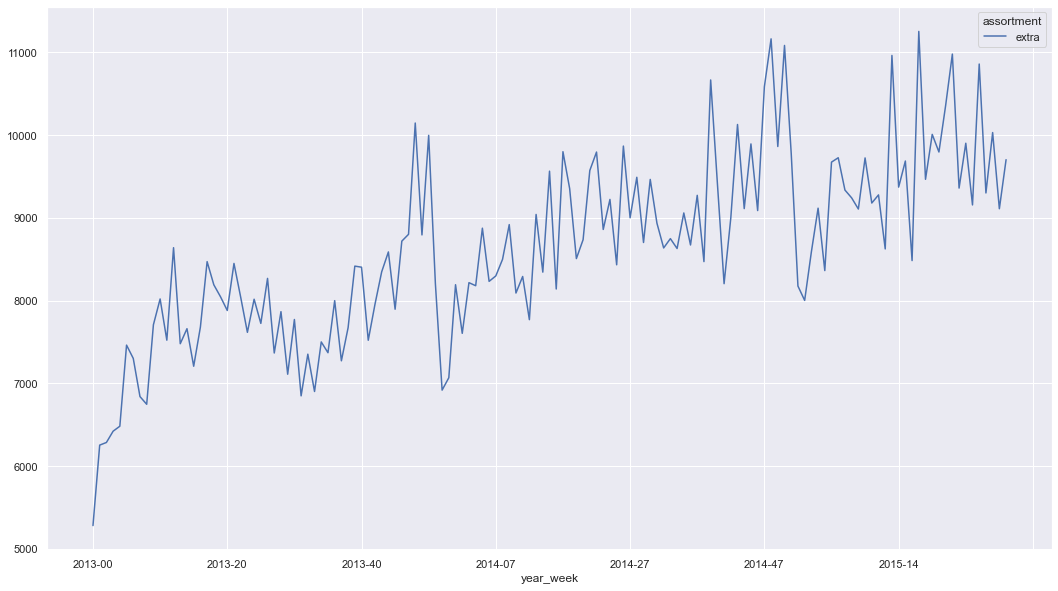

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos em mediana.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem aproximadamente IGUAIS a lojas mais distantes.

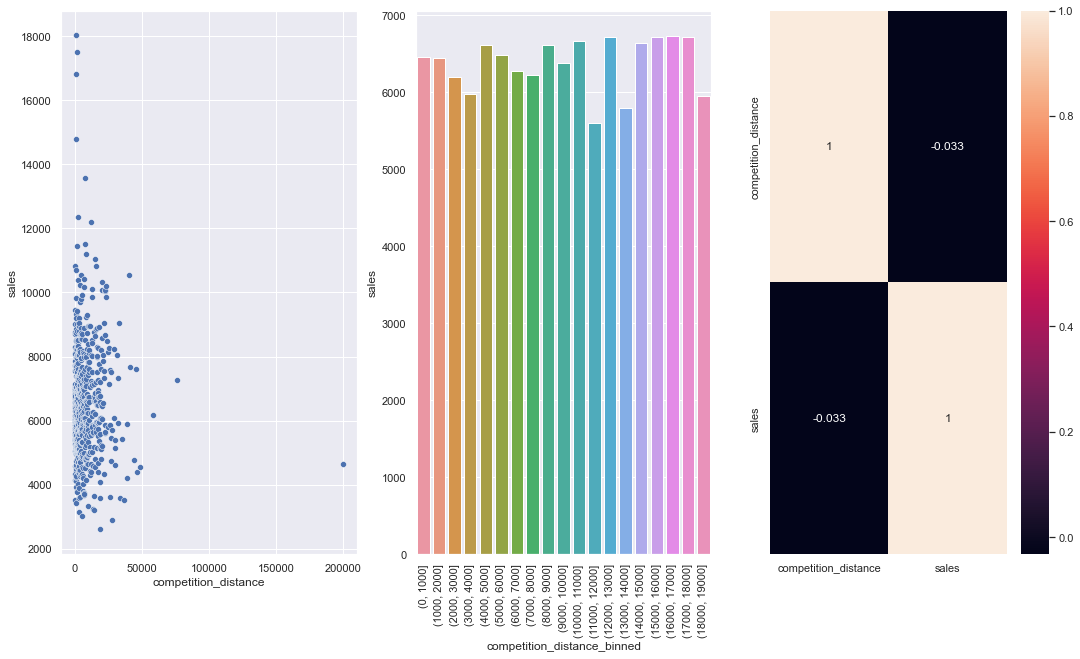

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais em mediana.

**VERDADEIRA** Lojas com COMPETIDORES A MAIS TEMPO vendem em média MAIS

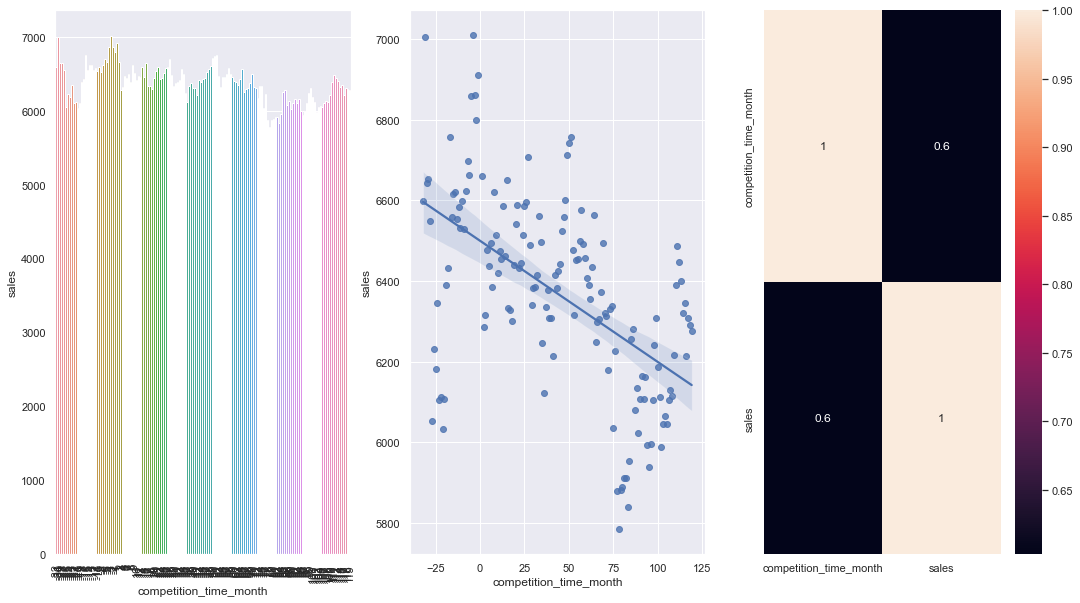

In [33]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo em media deveriam vender mais.
**VERDADEIRA** Lojas com promoções ativas vendem em média MAIS, depois de um curto período de tempo

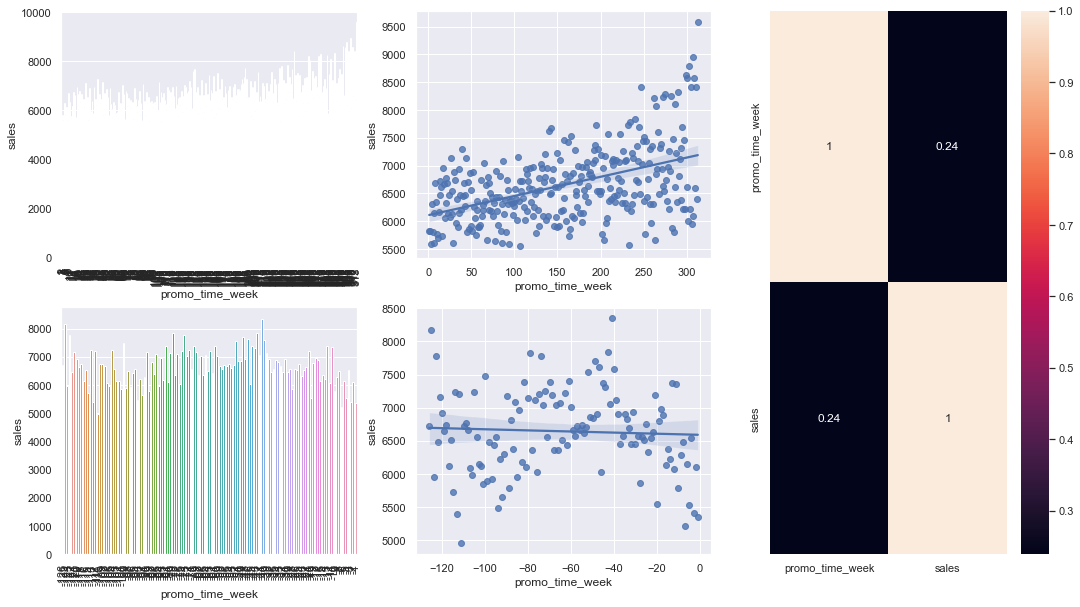

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais na media.</s> 
 Hipótese similar ao H4, seria necessário nova feature, portanto decidi realizar a validação apenas no próximo ciclo de projeto.

### H6. Lojas com mais promoções consecutivas deveriam vender mais na media.
**VERDADEIRA** Lojas com mais promoções consecutivas vendem em média MAIS.

In [35]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.19
1,0,1,5529.57
2,1,0,8618.45
3,1,1,7836.67


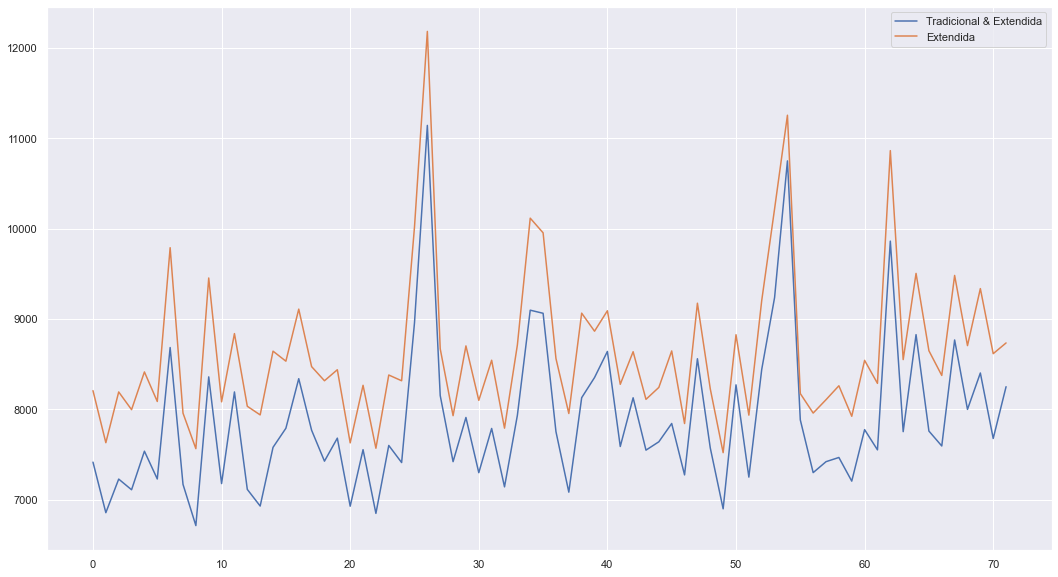

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas deveriam vender menos nos finais de semana.

**VERDADEIRA** Lojas vendem menos nos finais de semana

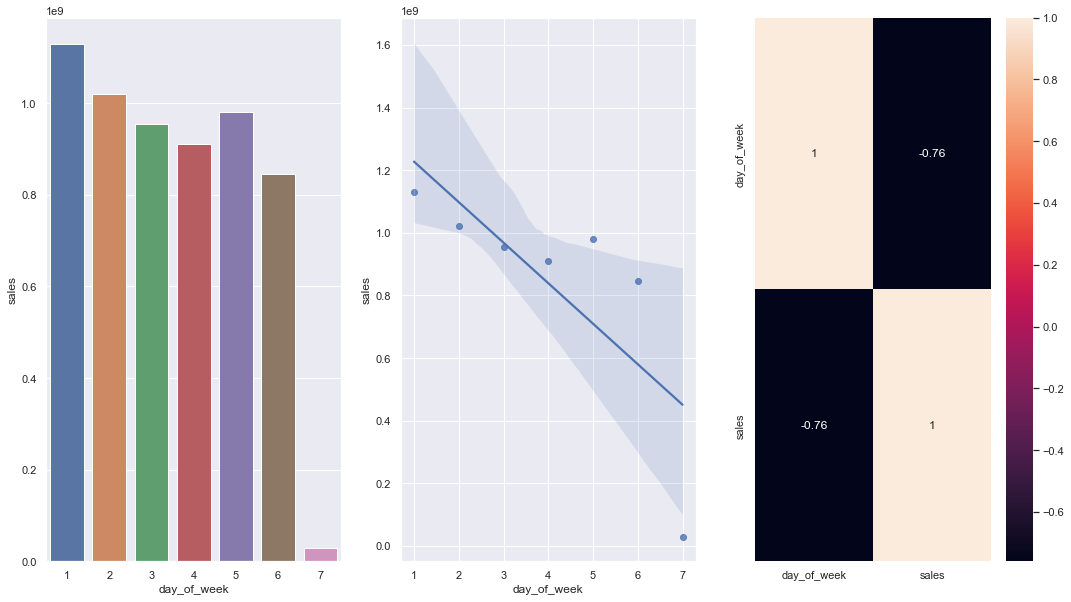

In [34]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais na media.

**FALSA** Lojas abertas durante o feriado de Natal vendem em média menos a lojas abertos nos feriados de páscoa e de estado.

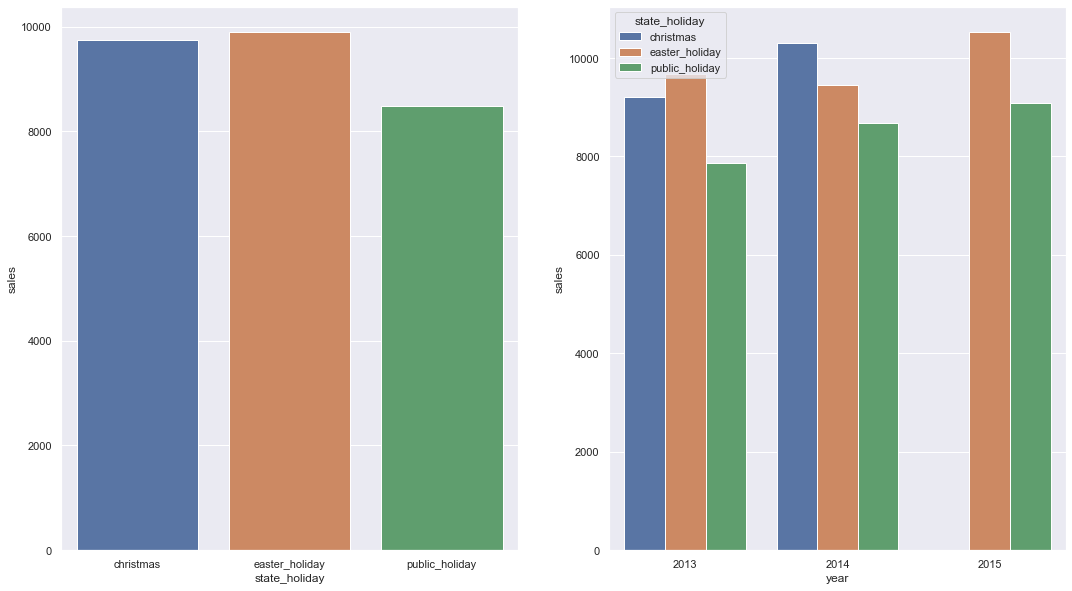

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Lojas em media deveriam vender mais ao longo dos anos.

**VERDADEIRA** Lojas vendem em média MAIS ao longo dos anos

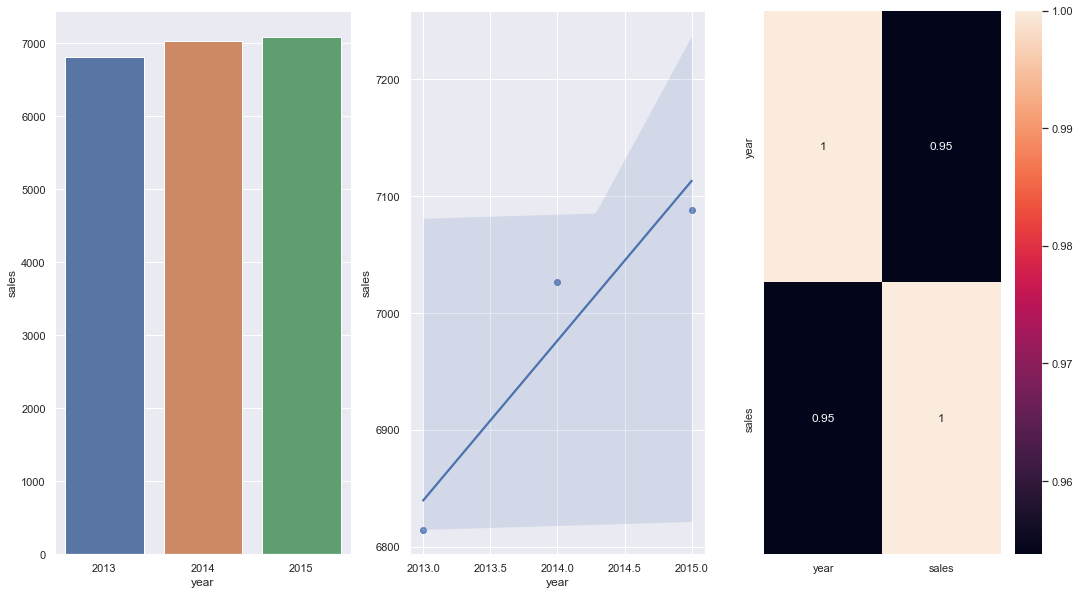

In [38]:
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas em media deveriam vender mais depois do dia 10 de cada mês.

**FALSA** Lojas vendem em media MENOS depois do dia 10 de cada mês

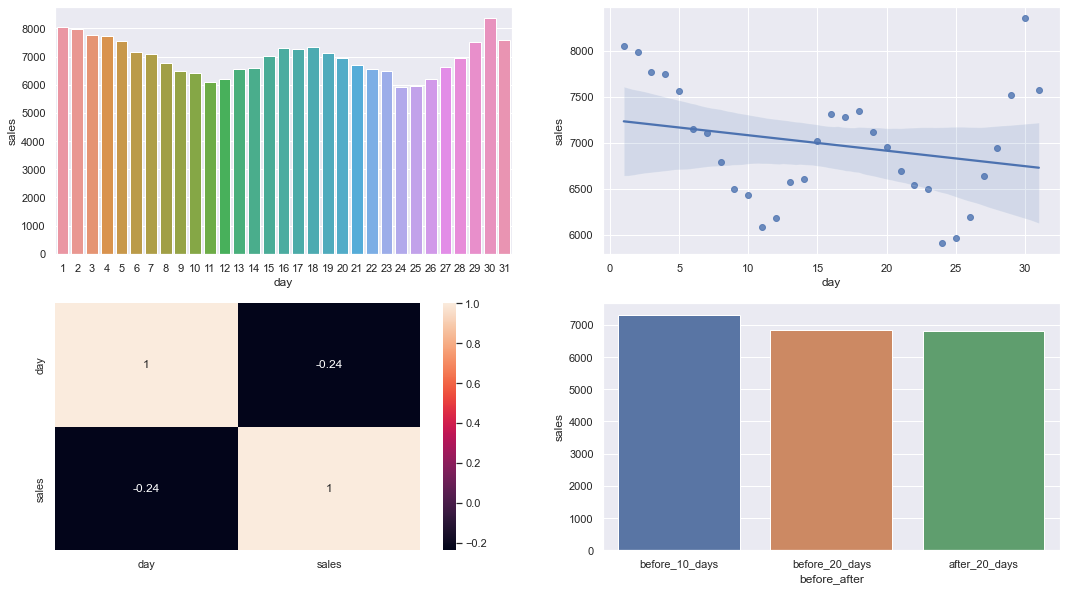

In [39]:
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else ('before_20_days' if x <= 20 else 'after_20_days'))
aux2 = aux1[['before_after', 'sales']].groupby('before_after').mean().sort_values('sales', ascending=False).reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas em media deveriam vender menos durante os feriados escolares.

**FALSA** Lojas vendem em média menos durante os feriados escolares, exceto no mês de Dezembro.

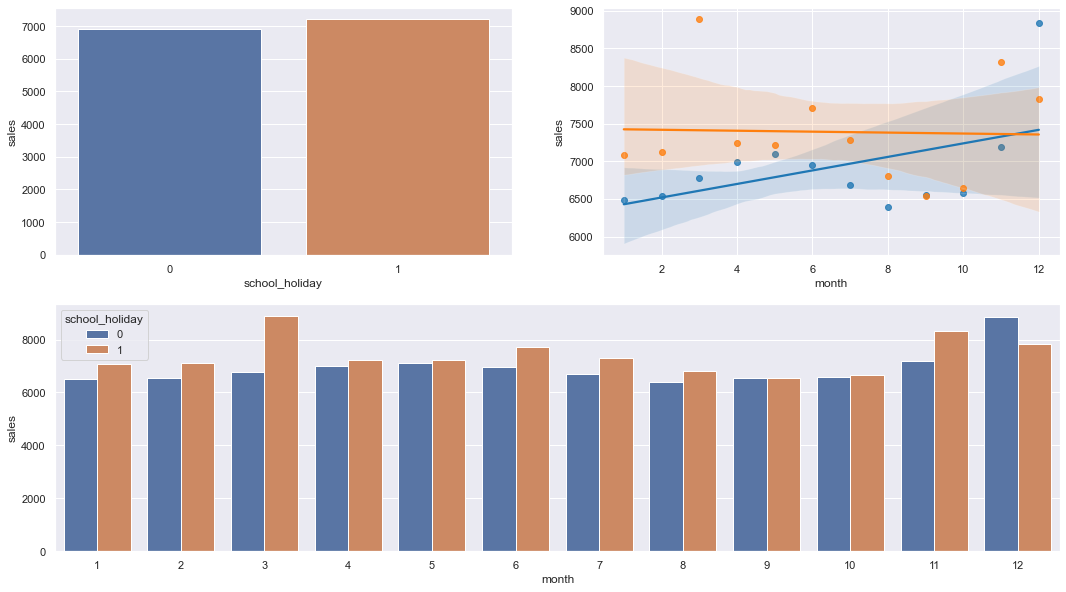

In [40]:
grid = GridSpec(2, 2)

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(grid[0,0])
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
plt.subplot(grid[0,1])
hue_regplot(data=aux2, x='month', y='sales', hue='school_holiday')

plt.subplot(grid[1,:])
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### H12. Lojas em media deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Lojas vendem em média MAIS no segundo semestre do ano.

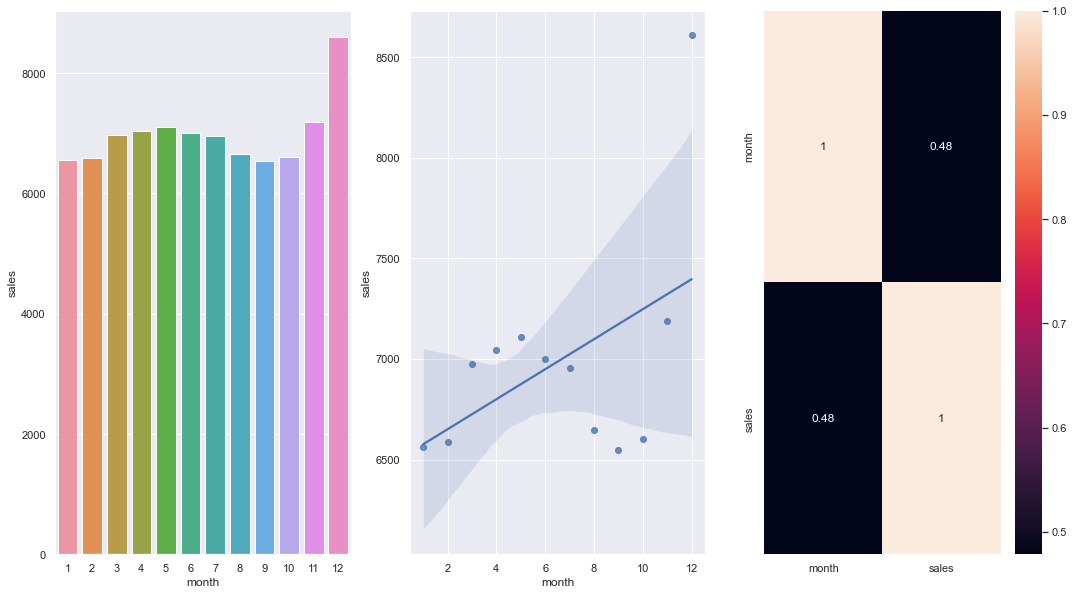

In [41]:
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [42]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Baixa'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Verdadeira', 'Alta'],
       ['H4', 'Verdadeira', 'Baixa'],
       ['H5', '~', '~'],
       ['H6', 'Verdadeira', 'Média'],
       ['H7', 'Verdadeira', 'Alta'],
       ['H8', 'Falsa', 'Baixa'],
       ['H9', 'Verdadeira', 'Alta'],
       ['H10', 'Falsa', 'Baixa'],
       ['H11', 'Falsa', 'Baixa'],
       ['H12', 'Verdadeira', 'Média'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Baixa
H3           Verdadeira   Alta
H4           Verdadeira   Baixa
H5           ~            ~
H6           Verdadeira   Média
H7           Verdadeira   Alta
H8           Falsa        Baixa
H9           Verdadeira   Alta
H10          Falsa        Baixa
H11          Falsa        Baixa
H12          Verdadeira   Média


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

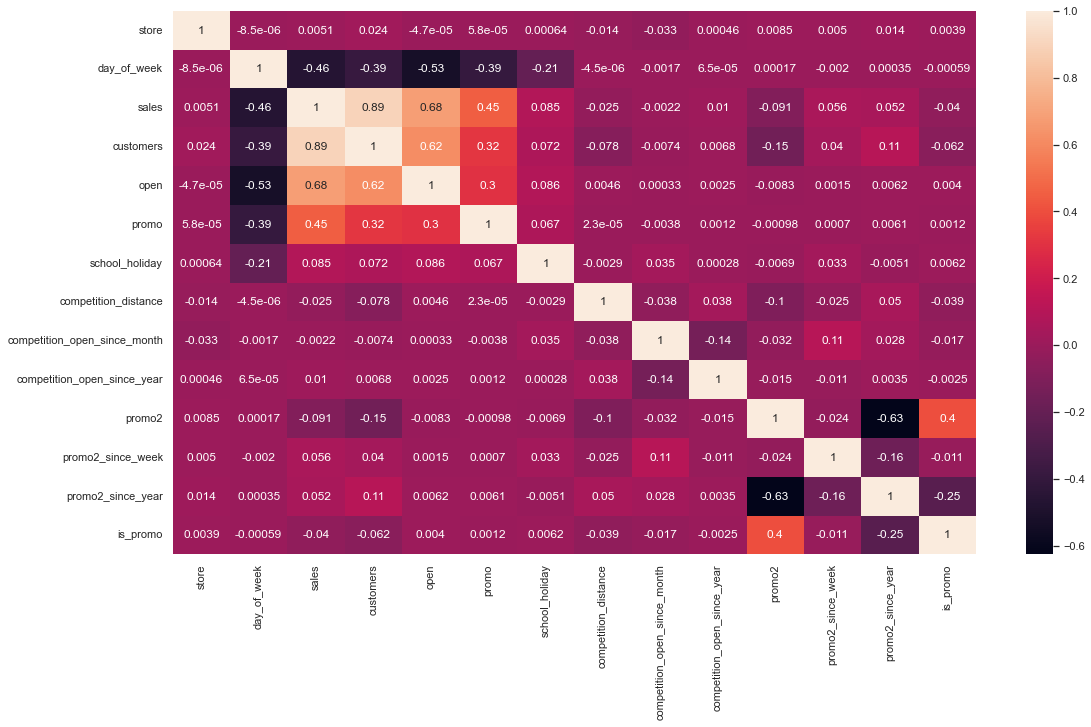

In [41]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

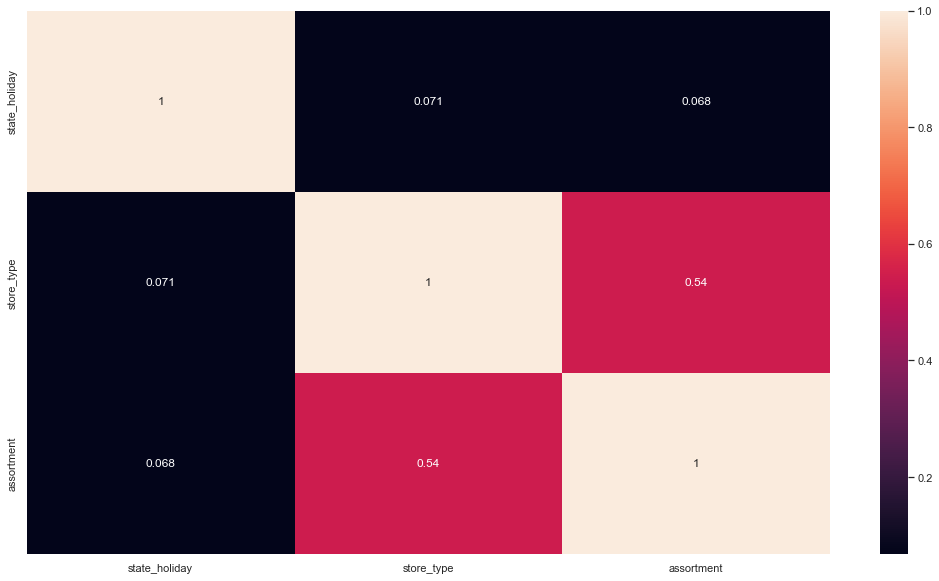

In [42]:
# only categorical data
a = df4.select_dtypes(include='object')

# Cramer V correlation
d = pycorrcat.corr_matrix(a, ['state_holiday', 'store_type', 'assortment'])
sns.heatmap(d, annot=True);

# 5.0 Preparação dos dados

In [43]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [45]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [46]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

In [47]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))

In [48]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

# 6.0 Feature Selection

In [49]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

In [50]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [51]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min date: {X_train["date"].min()}')
print(f'Training Max date: {X_train["date"].max()}')

print(f'\nTest Min date: {X_test["date"].min()}')
print(f'Test Max date: {X_test["date"].max()}')

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [52]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [53]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected]

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta.columns))


## 6.3 Manual Feature Selection

In [54]:
cols_not_selected_boruta = ['is_promo',
                             'month_sin',
                             'school_holiday',
                             'state_holiday_christmas',
                             'state_holiday_easter_holiday',
                             'state_holiday_public_holiday',
                             'state_holiday_regular_day',
                             'week_of_year_sin',
                             'year']

In [55]:
# features from boruta
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',  # manual selection
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin', # manual selection
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modeling

In [66]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average model

In [57]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


## 7.2 Linear Regression Model

In [58]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 7.2.1 Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [59]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


### 7.3.1 Lasso - Cross Validation

In [68]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [60]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.60,0.10,1011.12


### 7.4.1 Random Forest Regressor - Cross Validation

In [69]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [61]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.1,
                            max_depth=20, subsample=0.7, colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,675.77,0.10,984.42


### 7.5.1 XGBoost Regressor - Cross Validation

In [70]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5


F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 4


F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 3


F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 2


F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number: 1


F:\SamuelOliveiraAlvesd\Anaconda3\envs\Rossmann_Project\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,871.07 +/- 178.3,0.12 +/- 0.02,1260.15 +/- 259.21


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [62]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,675.77,0.10,984.42
0,Random Forest Regressor,679.60,0.10,1011.12
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1891.70,0.29,2744.45


### 7.6.2 Real Performance - Cross Validation

In [73]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,871.07 +/- 178.3,0.12 +/- 0.02,1260.15 +/- 259.21
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
